## Regexterminator script

### To do's:
- [ ] scrape SO and/or github for common regex solutions
- [ ] scrape for common regex problems/data sets to train on
- [ ] engineer features
   - [ ] checking out text aligning tools from genetics?
   - [ ] pre-trained NN layer for parts of text/speech?
- [ ] make model work
- [ ] make flask app/website
- [ ] take in multiple inputs examples
- [ ] take in feedback
- [ ] run on a cloud server, train massive dataset
- [ ] Use reinforcement somehow? reward short answers?


### common naming mix-ups
start and original, are the sentences/stings in the raw data

end and replacement are the sentences/string after the regex is applied

sentences are the input/example/sample to emulate what the user might enter. They do not need to be sentences with words, can be numbers, jibberisht, weird strings of characters etc. Hopefully something from a regular language though...

## fun times~!

In [1]:
%qtconsole #Initiate console

In [2]:
import pandas as pd
import difflib
import re
import pickle # exporting structures for external saves and quick read back into python
import string # for counting type of characters in strings

from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

In [3]:
path = "../"
path = "/Users/gregorystegeman/Documents/Regexterminator/"

# 1 Data Acquisition

In [4]:
#https://stackoverflow.com/questions/tagged/regex
'''
TODO: use stack overflow API to find top regex queries
Maybe searh for str.replace in gitHub

'''




'\nTODO: use stack overflow API to find top regex queries\nMaybe searh for str.replace in gitHub\n\n'

In [5]:
# Super simple set for easy following though pipeline here:

sample_regex_patterns = [r'\d+',
                         r'[a-z]',
                         r'[A-Z]',
                         r'\s',
                         r"[^A-Za-z0-9]",
                         r'[0-9]',
                        ]



In [6]:
sample_regex_patterns = [
    r'\d+',
    r'[a-z]',
    r'[A-Z]',
    r'\s',
    r'[^A-Za-z0-9]',
    r'[0-9]',
    r'http\S+',
    r'(.*);(.*)',
    r'^(\d{3})-(\d{3})-(\d{4})$',
    r'^(\d{3})\D+(\d{3})\D+(\d{4})\D+(\d+)$',
    r'([\w0-9_]+)',
    r'^.+',
    r'([^:：]+)[:：]?\s*',
    r'\d+/\d+/\d+',
    r'\.[0]*',
    r'[,;_]',
    r'[\w\d]{1,20}[\w]{1,20}[\w]{1,5}',
    r'(.+) \1',
    r'http\S+\s',
    r'RT|cc',
    r'[^A-Za-z0-9]+',
    r'\w',
    r'\n|\r',
    r'^([A-Za-z]\d[A-Za-z][-]?\d[A-Za-z]\d)',
    r'[:]{1}[-~+o]?[)&gt;]+',
    r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)',
    r'<[^>]*>',
    r'\xA9',
    r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',
    r'@\S+',
    r'#\S+',
    r'^\d+',
    r'^[a-z]',
    r'^[A-Z]',
    r'^\s',
    r"^[^A-Za-z0-9]",
    r'^[0-9]',
    
                        ]


In [7]:
#Create dictionary to reference regex pattern classes
regex_dict = {}
for i in sample_regex_patterns:
    regex_dict['c_'+ str(sample_regex_patterns.index(i))] = i
    
#Save regex_dict in pickle; move to flask app later
pickle.dump(regex_dict, open('regex_dict.pickle', 'wb'))

Scrape/acquire sentences from: 
- [ ] twitter
- [ ] wikipedia
- [ ] yelp reviews (Ming He)
- [ ] steam game reviews
- [ ] copy from other fellows
- [ ] Excel help forums
- [ ] amazon reviews (Patrick Lestrange)
- [ ] Medium (Kim S)
- [ ] StackOverFlow comment and questions
- [ ] BGG (Pam M)

Stuff to include
- numbers
- phone numbers
- postal codes
- email address
- code segments
- dates of different formats
- IP addresses
- addresses
- multi line?
- non standard characters?


In [8]:
# smaller test dataset
start_sentences = pd.read_csv(path + 'garbage_data.csv')

start_sentences = start_sentences["garbage data"].tolist()

In [10]:
#Downloaded random dataset from https://www.figure-eight.com/data-for-everyone/
df = pd.read_csv(path + '1377191648_sentiment_nuclear_power.csv', encoding = "ISO-8859-1")

#Only really care about tweet_text column
start_sentences = start_sentences + df.tweet_text.tolist()

In [11]:
# Add in 100 sample tweets from twitter100k dataset:
tweetlines = open(path + "tweet_samples.txt").read().splitlines()

start_sentences = start_sentences + tweetlines

In [12]:
# SMS messages from:
# https://github.com/kite1988/nus-sms-corpus
import json
with open(path + "smsCorpus_en_2015.03.09_all.json") as f:
    sms_data = json.load(f)

sms = sms_data['smsCorpus']
sms = sms.get('message')

sms_texts = []
for message in sms:
    sms_texts.append(message['text']['$'])

# Maybe random later, for now keep it the same:    
sms_subset = sms_texts[0:1000]

start_sentences = start_sentences + sms_subset

In [13]:
# Generate some fake number data and then mess it up
# phone numbers
# zipcodes
# prices


In [14]:
#Add to sentences a sentence that contains all alphanumeric characters that we ever expect to encounter

start_sentences.append('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuv')
start_sentences.append('`1234567890-=~!@#$%^&*()_+[]\{}|;\':\",./<>?')

In [15]:
# Force all things in list to be strings

start_sentences = [str(i) for i in start_sentences]

# 2 Feature Engineering

## 2.0 Generate training data with unmodified/start sentence and a processed replacement/end sentence.

In [21]:
'''
Create a new data frame that captures both the regex and also the 
sentence transformation
'''
start_regexed_end = pd.DataFrame() #Initialize empty data frame

for regex in sample_regex_patterns:
    for sentence in start_sentences:
        r = re.compile(regex)
        d = {
            'sentence': sentence,
            'regex': regex,
            'replacement': re.sub(r,'',sentence)
        }
        
        start_regexed_end = start_regexed_end.append(d, ignore_index=True)

In [22]:
# Save/pickle it, that takes a long time to run:

pickle.dump(start_regexed_end, open('start_regexed_end.pickle', 'wb'))

start_regexed_end = pickle.load(open('start_regexed_end.pickle', 'rb'))

In [25]:
# How much was changed/affected by regex's?

'''
1. Find if difference between start_regexed_end.sentence & start_regexed_end.replacement
2. Group by 'regex'
'''

#print(start_regexed_end.groupby(['regex']).sum(start_regexed_end['sentence'] != start_regexed_end['replacement']))      
start_regexed_end[start_regexed_end.sentence == start_regexed_end.replacement].groupby('regex').count()

,replacement,sentence
regex,,
#\S+,1221,1221
(.*);(.*),1296,1296
(.+) \1,975,975
(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+),43,43
(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$),1215,1215
<[^>]*>,1325,1325
@\S+,1115,1115
RT|cc,1197,1197
"[,;_]",1127,1127


In [ ]:
# Also wondering which regex give the same result from each processing.
# Which are redundant or overlapping all the time or part of the time?

In [26]:
start_regexed_end.head()

,regex,replacement,sentence
0,\d+,blah blah! BLAH!!!,blah blah! BLAH!!!
1,\d+,hjhjhj,42hj43hj34hj43
2,\d+,..gf;gfsd;gg;,4.243.gf;gfsd;3g3g;
3,\d+,fdsa.l fef. rlfkk,fdsa.2l fe3f. rlfkk
4,\d+,derp derp doop.!!!,derp derp doop.!!!


## 2.1 Find differences between `start` and `end` sentence inputs

In [27]:
def charCounts(column, colname):
    """
    Counts the different type of characters in a string
    
    @param column: to apply lambda function to
    @param colname: what the unique columns should be named
    
    """
    # This is really ugly, something I could do in R very easily:
    count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

    out = column.apply(
    lambda s: pd.Series(
        {colname+'punct': count(s,set(string.punctuation)),
         colname+'letters': count(s,set(string.ascii_letters)),
         colname+'digits': count(s,set(string.digits)),
         colname+'lower': count(s,set(string.ascii_lowercase)),
         colname+'upper': count(s,set(string.ascii_uppercase)),
         colname+'whitespace': count(s,set(string.whitespace)),
         colname+'words': len(s.split()),
        }))
    return out

In [28]:
start_counts = charCounts(start_regexed_end['sentence'], 'start_n_')
end_counts = charCounts(start_regexed_end['replacement'], 'end_n_')

type_counts = pd.concat([start_regexed_end, start_counts, end_counts], axis= 1)


In [29]:
type_counts.head()

,regex,replacement,sentence,start_n_punct,start_n_letters,start_n_digits,start_n_lower,start_n_upper,start_n_whitespace,start_n_words,end_n_punct,end_n_letters,end_n_digits,end_n_lower,end_n_upper,end_n_whitespace,end_n_words
0,\d+,blah blah! BLAH!!!,blah blah! BLAH!!!,4,12,0,8,4,2,3,4,12,0,8,4,2,3
1,\d+,hjhjhj,42hj43hj34hj43,0,6,8,6,0,0,1,0,6,0,6,0,0,1
2,\d+,..gf;gfsd;gg;,4.243.gf;gfsd;3g3g;,5,8,6,8,0,0,1,5,8,0,8,0,0,1
3,\d+,fdsa.l fef. rlfkk,fdsa.2l fe3f. rlfkk,2,13,2,13,0,2,3,2,13,0,13,0,2,3
4,\d+,derp derp doop.!!!,derp derp doop.!!!,4,12,0,12,0,2,3,4,12,0,12,0,2,3


## More feature engineering

sequences of similar character types (letter, number, white space and punctuation)

beginning and ends of sentences

word boundaries




In [30]:

def endChecks(dataf, start_col, end_col, regex = False):
    """
    Checks if end words and characters are the same between two strings (from columns)
    
    @param dataf: pandas dataframe.
    @param start_col: initial string
    @param end_col: modified string to compare to
    @param regex: include regex in new table for indexing.
    
    @return: returns dataframe with start column and regex for indexing, and four new columns of features
    """
    out = pd.DataFrame()
    for index, row in dataf.iterrows():
        tmp = {
            start_col: row[start_col],
            'regex': row['regex'] if regex else '',
            'first_word_same': row[start_col].split()[0] == row[end_col].split()[0] if len(row[end_col].split())>0 else False,
            'first_char_same': row[start_col][0] == row[end_col][0] if len(row[end_col].split())>0 else False,
            'last_word_same': row[start_col].split()[-1] == row[end_col].split()[-1] if len(row[end_col].split())>0 else False,
            'last_char_same': row[start_col][-1] == row[end_col][-1] if len(row[end_col].split())>0 else False,
        }
        out = out.append(tmp, ignore_index=True)
        
    return out

In [31]:
string_ends = endChecks(start_regexed_end, 'sentence','replacement', regex = True)

### more features?

position of difference

difference at beginning or end?

aligned difference?

# 3 Test/Train data splits

## 3.1 Feature Variables (X)

In [67]:
# Combine features I want to work with and drop the label stuff

#list(dummies.columns.values)
list(type_counts.columns.values)

features_combo = pd.merge(type_counts, string_ends, on=["sentence","regex"])

list(features_combo.columns.values)

X = features_combo.drop(['sentence', 'regex', 'replacement'], axis=1).values #Remove everything but the feature variables
X = features_combo.drop(['sentence', 'regex', 'replacement'], axis=1) #Remove everything but the feature variables





In [68]:
features_combo.head()

,regex,replacement,sentence,start_n_punct,start_n_letters,start_n_digits,start_n_lower,start_n_upper,start_n_whitespace,start_n_words,...,end_n_letters,end_n_digits,end_n_lower,end_n_upper,end_n_whitespace,end_n_words,first_char_same,first_word_same,last_char_same,last_word_same


## 3.2 Target Variable (Y)

In [69]:
'''
Convert regex labels to numeric value depending on where it occurs in the sample_regex_patterns list
'''
y = ['c_'+str(sample_regex_patterns.index(i)) for i in features_combo.regex]

#Find the value (features_combo.regex) for the key in regex_dict
def findRegexClass(dict_to_search, dict_value):
    """
    Function to find the key 
    
    @param dict_to_search: The dict to search for the key for the given value
    @param dict_value: The value to find the corresponding key for
    
    @return: the key
    """
    return [key for key, value in dict_to_search.items() if dict_value == value][0]

# For each regex in dummies.regex, find the corresponding class/key to form the y-label
y = [findRegexClass(regex_dict, i) for i in features_combo.regex]

## 3.3 Test/Train data split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [289]:
#https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html
'''import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)'''

"import xgboost as xgb\ndtrain = xgb.DMatrix(X_train, label=y_train)\ndtest = xgb.DMatrix(X_test, label=y_test)\n\nparam = {\n    'max_depth': 3,  # the maximum depth of each tree\n    'eta': 0.3,  # the training step for each iteration\n    'silent': 1,  # logging mode - quiet\n    'objective': 'multi:softprob',  # error evaluation for multiclass training\n    'num_class': 3}  # the number of classes that exist in this datset\nnum_round = 20  # the number of training iterations\n\nbst = xgb.train(param, dtrain, num_round)"

# 4 Model Fitting & Hyperparameter tuning

# 4.1 Random Forest

In [64]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train, sample_weight=None, check_input=True)

cross_val_score(clf, X_train, y_train, cv=10)
#cross_val_score(clf, iris.data, iris.target, cv=10)


array([0.15979496, 0.15774208, 0.15520322, 0.15377738, 0.15525727,
       0.16267621, 0.15916723, 0.16098655, 0.15417415, 0.1661801 ])

## 4.2 Boosted Gradient Tree?

XG Boost?


In [37]:
# fit model to training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

print(xgb_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase

LR: 0.247271 (0.005717)


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn

LDA: 0.191561 (0.007117)
KNN: 0.135135 (0.004719)
CART: 0.159052 (0.004795)
NB: 0.214292 (0.008149)


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

SVM: 0.141400 (0.003581)


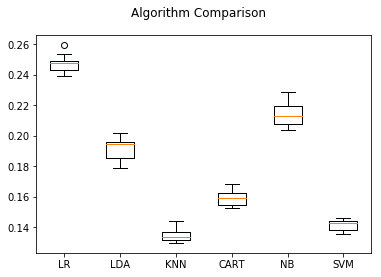

In [71]:
# From: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load dataset
#url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = pandas.read_csv(url, names=names)
#array = dataframe.values
X = X_train
Y = y_train
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# 5 Model Selection

In [291]:
#Code here to select best model

In [63]:
#Code here to pickle best model, so that it can be transfered to Flask + HTML

# save the model to disk; move this into the flask app
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

'''
# Code to load model later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
'''

"\n# Code to load model later...\n \n# load the model from disk\nloaded_model = pickle.load(open(filename, 'rb'))\n"

# 6 Predict

In [45]:
# Data to predict regex class for
a = 'a is the original sentence, b is the replacement sentence!'
b = 'a is the original sentence b is the replacement sentence'

In [331]:
# Data to predict regex class for
a = 'blah blah1 blah1114324'
b = 'blah blah blah'

In [38]:
# Data to predict regex class for
a = '4324£ ⇐'
b = '4324'

In [46]:
# because some of my functions from earlier need columns not raw strings:
user_inputs = {'sentence': [a], 'end': [b]}
user_inputs = pd.DataFrame(user_inputs)

# 6.1 Data Transformation
Transform the new input data to fit the model input structure

In [47]:
#add in character type counts features

a_counts = charCounts(user_inputs['sentence'], 'start_n_')
b_counts = charCounts(user_inputs['end'], 'end_n_')

input_type_counts = pd.concat([user_inputs, a_counts, b_counts], axis= 1)

#string ends feature:
string_ends = endChecks(user_inputs, 'sentence','end', regex = False)

input_features_combo = pd.merge(input_type_counts, string_ends, on="sentence")

X_new = input_features_combo.drop(['sentence','regex','end'], axis=1)

#list(input_features_combo.columns.values)

In [56]:
# As a function:
def cleanInput(a, b):
    """
    Function to perform feature transformation & engineering 

    @param a: uncleaned sentence
    @param b: desired output sentence 

    @return: feature transformed data
    """
    user_inputs = {'sentence': [a], 'end': [b]}
    user_inputs = pd.DataFrame(user_inputs)

    #add in character type counts features

    a_counts = charCounts(user_inputs['sentence'], 'start_n_')
    b_counts = charCounts(user_inputs['end'], 'end_n_')

    input_type_counts = pd.concat([user_inputs, a_counts, b_counts], axis= 1)

    #string ends feature:
    string_ends = endChecks(user_inputs, 'sentence','end', regex = False)

    input_features_combo = pd.merge(input_type_counts, string_ends, on="sentence")

    X_new = input_features_combo.drop(['sentence','regex','end'], axis=1).values

    return X_new

In [58]:
X_new = cleanInput(a,b)

X_new

array([[ 2., 47.,  0., 47.,  0.,  9., 10.,  0., 47.,  0., 47.,  0.,  9.,
        10.,  1.,  1.,  0.,  0.]])

## 6.2 Predict Class
TODO: For multiple inputs, find median/average highest scored class

In [59]:
#Now input into the model to predict the class
predicted_y = clf.predict(X = X_new)

In [60]:
#Match that value back to the initial class
[regex_dict.get(y) for y in predicted_y]

['\\.[0]*']

In [61]:
#predicted probabilities of each class
#https://datascience.stackexchange.com/questions/22762/understanding-predict-proba-from-multioutputclassifier
clf.predict_proba(X_new)[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [62]:
r = re.compile([regex_dict.get(y) for y in predicted_y][0])
print("        a:", a)
print("        b:", b)
print("predicted:", re.sub(r,'',a))
print("    using:", [regex_dict.get(y) for y in predicted_y][0])



        a: a is the original sentence, b is the replacement sentence!
        b: a is the original sentence b is the replacement sentence
predicted: a is the original sentence, b is the replacement sentence!
    using: \.[0]*


# 7 code for visualizations and explorations

In [300]:
# Visualize the decision tree:
# From https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

# Extract single tree
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

AttributeError: 'DecisionTreeClassifier' object has no attribute 'estimators_'

# Dumping Ground for old code snippets

In [182]:
'''
break original sentence and replacement sentence columns into character counts/presence.
'''

def characterTable(ref_sentence, sentence, regex = None):
    """
    Break up sentence by character into data frame
    
    @param ref_sentence: the original sentence, which is used as a reference. Not broken-up
    @param sentence: the sentence to break up by character
    @param: regex: the regex reference
    """
    out = pd.DataFrame(data={
        'sentence': ref_sentence,
        'regex': regex,
        'char': [i for i in sentence]
    })
    return out

start_by_char = pd.DataFrame()

for index, row in start_regexed_end.iterrows():
    chartable = characterTable(row.sentence, row.sentence, row.regex)
    start_by_char = start_by_char.append(chartable)


end_by_char = pd.DataFrame()

for index, row in start_regexed_end.iterrows():
    chartable = characterTable(row.sentence, row.replacement, row.regex)
    end_by_char = end_by_char.append(chartable)

KeyboardInterrupt: 

In [12]:
'''
Use dummies to transpose the character column into their own columns for each character.
'''
dummies_start = pd.get_dummies(start_by_char, prefix='char_start', columns=['char'])
dummies_end = pd.get_dummies(end_by_char, prefix='char_end', columns=['char'])



# Define the feature columns
r = re.compile('^char\_start\_.*')
char_start_cols = list(filter(r.match, dummies_start.columns))

dummies_start = dummies_start.groupby(['sentence','regex'])[char_start_cols].sum().reset_index()#Now sum up the values

r = re.compile('^char\_end\_.*')
char_end_cols = list(filter(r.match, dummies_end.columns))

dummies_end = dummies_end.groupby(['sentence','regex'])[char_end_cols].sum().reset_index()#Now sum up the values



In [13]:
dummies_end.head()

,sentence,regex,char_end_,char_end_!,"char_end_""",char_end_#,char_end_$,char_end_%,char_end_&,char_end_',...,char_end_|,char_end_},char_end_~,char_end_,char_end_¨,char_end_É,char_end_Ê,char_end_Ð,char_end_Ò,char_end_Õ
0,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[0-9],17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[A-Z],17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[^A-Za-z0-9],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[a-z],17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",\d+,17,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [14]:
'''
Combine two dummies tables with start sentence, end sentence and regex

May need to rename some columns with strange characters
'''

# Want to combine the start_regexed_end table and the new dummies_start and dummies_end
# Should combine dummies first?
# For now keeping dummies table separate from full combo of data, 
# want to keep set of engineered features separate and combine later.

dummies_all = pd.merge(dummies_start, dummies_end, on=["sentence","regex"])



In [15]:
'''
Because the algorithms don't like when there are feature names that contain [, ] or <, just rename them
Jan 31- right now algorithm doesn't take any feature names at all.
'''

dummies = dummies_all.copy()

# Pickle dummies column names for later use; move this into the flask app
dummies_cols = dummies_all.columns
pickle.dump(dummies_cols, open('dummies_cols.pickle', 'wb'))

# rename offending columns
dummies = dummies.rename(columns={
    'char_start_[': 'char_start_left_square_bracket',
    'char_start_]': 'char_start_right_square_bracket',
    'char_start_<': 'char_start_left_carrot',
    'char_end_[': 'char_end_left_square_bracket',
    'char_end_]': 'char_end_right_square_bracket',
    'char_end_<': 'char_end_left_carrot'})

# Check it out:
list(dummies.columns.values)


['sentence',
 'regex',
 'char_start_ ',
 'char_start_!',
 'char_start_"',
 'char_start_#',
 'char_start_$',
 'char_start_%',
 'char_start_&',
 "char_start_'",
 'char_start_(',
 'char_start_)',
 'char_start_*',
 'char_start_+',
 'char_start_,',
 'char_start_-',
 'char_start_.',
 'char_start_/',
 'char_start_0',
 'char_start_1',
 'char_start_2',
 'char_start_3',
 'char_start_4',
 'char_start_5',
 'char_start_6',
 'char_start_7',
 'char_start_8',
 'char_start_9',
 'char_start_:',
 'char_start_;',
 'char_start_left_carrot',
 'char_start_=',
 'char_start_>',
 'char_start_?',
 'char_start_@',
 'char_start_A',
 'char_start_B',
 'char_start_C',
 'char_start_D',
 'char_start_E',
 'char_start_F',
 'char_start_G',
 'char_start_H',
 'char_start_I',
 'char_start_J',
 'char_start_K',
 'char_start_L',
 'char_start_M',
 'char_start_N',
 'char_start_O',
 'char_start_P',
 'char_start_Q',
 'char_start_R',
 'char_start_S',
 'char_start_T',
 'char_start_U',
 'char_start_V',
 'char_start_W',
 'char_start_X'

In [343]:
# OLD CODE FOR DUMMIES TABLE FROM USER INPUTS

'''
OLD- These features no longer work for the training set.
Make dummies table for new inputs like I did with the training data
'''
a_start = characterTable(a,a)
b_end = characterTable(a,b)

'''
Use dummies to transpose the character column into their own columns for each character.
'''
dummies_a = pd.get_dummies(a_start, prefix='char_start', columns=['char'])
dummies_b = pd.get_dummies(b_end, prefix='char_end', columns=['char'])

dummies_to_fit = dummies_to_fit.reindex(columns = dummies_cols, fill_value=0)

# Define the feature columns
r = re.compile('^char\_start\_.*')
input_char_start_cols = list(filter(r.match, dummies_a.columns))

input_dummies_start = dummies_a.groupby(['sentence'])[input_char_start_cols].sum().reset_index()#Now sum up the values

r = re.compile('^char\_end\_.*')
input_char_end_cols = list(filter(r.match, dummies_b.columns))

input_dummies_end = dummies_b.groupby(['sentence'])[input_char_end_cols].sum().reset_index()#Now sum up the values

input_dummies = pd.merge(input_dummies_start, input_dummies_end, on="sentence")

'''
Reindex the dummies table to the old columns list so the # of columns will match.
This will cause model/site to break? Seems to handle: ⇐
If the inputs have characters the model was never trained on this will cause mismatches in the number of columns.
'''
dummies_to_fit = input_dummies.reindex(columns = dummies_cols, fill_value=0)

# rename offending columns
dummies_to_fit = dummies_to_fit.rename(columns={
    'char_start_[': 'char_start_left_square_bracket',
    'char_start_]': 'char_start_right_square_bracket',
    'char_start_<': 'char_start_left_carrot',
    'char_end_[': 'char_end_left_square_bracket',
    'char_end_]': 'char_end_right_square_bracket',
    'char_end_<': 'char_end_left_carrot'})



In [34]:
'''
# More features?
# Character counts by type (number, alphabet, punct etc.)

# This is really ugly, something I could do in R very easily:
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

start_counts = start_regexed_end['sentence'].apply(
    lambda s: pd.Series(
        {'start_n_punct': count(s,set(string.punctuation)),
         'start_n_letters': count(s,set(string.ascii_letters)),
         'start_n_digits': count(s,set(string.digits)),
         'start_n_lower': count(s,set(string.ascii_lowercase)),
         'start_n_upper': count(s,set(string.ascii_uppercase)),
         'start_n_whitespace': count(s,set(string.whitespace)),
         'start_n_words': len(s.split())
        }))

end_counts = start_regexed_end['replacement'].apply(
    lambda s: pd.Series(
        {'end_n_punct': count(s,set(string.punctuation)),
         'end_n_letters': count(s,set(string.ascii_letters)),
         'end_n_digits': count(s,set(string.digits)),
         'end_n_lower': count(s,set(string.ascii_lowercase)),
         'end_n_upper': count(s,set(string.ascii_uppercase)),
         'end_n_whitespace': count(s,set(string.whitespace)),
         'end_n_words': len(s.split()),
        }))

type_counts = pd.concat([start_regexed_end, start_counts, end_counts], axis= 1)
'''

In [ ]:
#start_regexed_end.sentence[0].split() # Good for words later
start_regexed_end.sentence[0][0] #can index by character position

## 2.2 Format differences into dummy variables
1. [x] Create dummy variables for each character in sentence
2. [ ] Create a second dummy table that captures the number of deletions that occur

In [21]:
'''
For each sentence X regex combo:
1. find all the diffs, and then match the characters with dummies, and remove that amount from dummies
'''



'\nFor each sentence X regex combo:\n1. find all the diffs, and then match the characters with dummies, and remove that amount from dummies\n'

In [22]:
'''
Because the algorithms don't like when there are feature names that contain [, ] or <, just rename them
'''

dummies = dummies_original.copy()

#Pickle dummies column names for later use; move this into the flask app
dummies_cols = dummies_original.columns
pickle.dump(dummies_cols, open('dummies_cols.pickle', 'wb'))

dummies = dummies.rename(columns={'char_[': 'char_left_square_bracket', 'char_]': 'char_right_square_bracket',
                       'char_<': 'char_left_carrot'})

In [23]:
"""
Because diffs causes multiple training instances, just drop 'diff' for now and then find the column sums
"""
dummies = dummies.drop(['diffs'], axis=1) #Drop columns

#Define the feature columns
r = re.compile('^char\_.*')
char_cols = list(filter(r.match, dummies.columns))

dummies = dummies.groupby(['sentence','regex'])[char_cols].sum().reset_index()#Now sum up the values

### Features capturing differences

In [24]:
#Create dummies for the differences when they occur
'''
1. If diffs == '-', then create/find column with char
'''
sent.loc[sent.diffs=='-'].groupby(['sentence','regex','char'])['diffs'].count().reset_index()

,sentence,regex,char,diffs
0,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",",",1
1,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",0,3
2,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",1,2
3,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",2,5
4,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?...",3,1
5,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",[ES],S,2
6,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",,17
7,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",#,2
8,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",.,1
9,"(Aug 22,2011)Plant Status of Fukushima Daiichi...","[^A-Za-z0-9(),!?@\'\`\""\_\n]",:,1


In [ ]:
# Figuring out shit for character type counting etc.

'start_n_': count(s,set(string.)),

def mo(input1):
    return input1.count("!")+2

def mo2(input1):
    return input1.count("!") + 22


aux = start_regexed_end['sentence'].apply(lambda x: pd.Series({'feature1':mo(x), 'feature2':mo2(x)}))


modf = pd.concat([start_regexed_end, aux], axis= 1)
modf.head()


# make new df to store these features in

counts = pd.DataFrame(columns = ['sentence','regex', # for indexing
                                 'start_n_alphabet', # alphabetical characters
                                 'end_n_alphabet',
                                 'start_n_numeric', # numeric characters
                                 'end_end_numeric',
                                 'start_n_punct', # punctuations
                                 'end_n_punct'])

for index, row in start_regexed_end.iterrows():
    
    print(len([c for c in row.sentence if c.isdigit()])) # start numbers
    print(len([c for c in row.replacement if c.isdigit()])) # end numbers

    
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
count(s,set(string.punctuation))
count(s,set(string.ascii_letters))
count(s,set(string.digits))
count(s,set(string.ascii_lowercase))
count(s,set(string.ascii_uppercase))
count(s,set(string.whitespace))



# words split on whitespace?
len(s.split())

# count white space
len(s) - len(s.strip())

string.ascii_letters

string.numbers

s = 'abcd!!!'

count(s,set(string.punctuation))       
    
import string
a = "I'm not gonna post my homework as question on OS again, I'm not gonna..."

count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

a_chars =  count(a, string.ascii_letters)
a_punct = count(a, string.punctuation)

    
    
start_regexed_end.apply(lambda sentence: len([c for c in sentence if c.isdigit()]))

In [ ]:



for index, row in start_regexed_end.iterrows():
    print(len([c for c in row.sentence if c.isdigit()]))


len([c for c in s if c.isdigit()])


sum(c.isdigit() for c in s) 

# punctuations


#start_regexed_end.sentence[0].split() # Good for words later
start_regexed_end.sentence[0][0] #can index by character position

len(start_regexed_end.sentence[0])

[c for c in start_regexed_end.sentence[0] if c.isdigit()]


len([c for c in start_regexed_end.sentence[10] if c.isdigit()])


def characterTable(ref_sentence, sentence, regex = None):
    """
    Break up sentence by character into data frame
    
    @param ref_sentence: the original sentence, which is used as a reference. Not broken-up
    @param sentence: the sentence to break up by character
    @param: regex: the regex reference
    """
    out = pd.DataFrame(data={
        'sentence': ref_sentence,
        'regex': regex,
        'char': [i for i in sentence]
    })
    return out

start_by_char = pd.DataFrame()

for index, row in start_regexed_end.iterrows():
    chartable = characterTable(row.sentence, row.sentence, row.regex)
    start_by_char = start_by_char.append(chartable)



In [ ]:
'''
OLD CELL!

Cool, created this data frame with some dummy data! 
But we should create some actual features that might important, e.g., difference
'''
def calcDiffs(a,b, regex = None):
    d = difflib.Differ()
    diff = d.compare(a,b)
    tmp = list(diff)
    out = pd.DataFrame(data={
        'sentence': a,
        'regex': regex,
        #'diffs': [i[0] for i in tmp],
        'char': [i[2] for i in tmp]
    })
    
    return out

sent = pd.DataFrame()
for index, row in dat.iterrows():
    a = row.sentence
    b = row.replacement
    
    out = calcDiffs(a,b,row.regex)
    
    sent = sent.append(out)

In [ ]:





    
'''
Using the dummies table from the trained data set, reindex the new dummies to fit the same standard
https://stackoverflow.com/questions/28465633/easy-way-to-apply-transformation-from-pandas-get-dummies-to-new-data
'''
dummies_to_fit = pd.get_dummies(out, columns=['char'])

#dummies_to_fit = dummies_to_fit.reindex(columns = dummies_cols, fill_value=0)
# need to reindex on new feature set

#Rename the columns
# need to check the order this happens
dummies_to_fit = dummies_to_fit.rename(
    columns={'char_[': 'char_left_square_bracket',
             'char_]': 'char_right_square_bracket',
             'char_<': 'char_left_carrot'})

#


X_new = dummies_to_fit.drop(['sentence', 'regex',], axis=1) #Remove everything but the dummy variables

#For whatever reason it's creating a separate matrix for each one. Add them all together instead
X_new = X_new.sum().values

#Reshape data for single sample
X_new = X_new.reshape(1, -1)

#add in character type counts features

a_counts = charCounts(user_inputs['start'], 'start_n_')
b_counts = charCounts(user_inputs['end'], 'end_n_')

input_type_counts = pd.concat([user_inputs, a_counts, b_counts], axis= 1)

input_features_combo = pd.merge(input_type_counts, dummies_to_fit, on="sentence")

list(features_combo.columns.values)

